# Frozen Lake
![Funny Cat](image/frozen_lake.gif)

Frozen lake involves crossing a frozen lake from Start(S) to Goal(G) without falling into any Holes(H) by walking over the Frozen(F) lake. The agent may not always move in the intended direction due to the slippery nature of the frozen lake.

# Rewards

Reach goal(G): +1

Reach hole(H): 0

Reach frozen(F): 0

In [22]:
"""
FrozenLake 4x4 Map:
[
    "SFFF",
    "FHFH",
    "FFFH",
    "HFFG"
]

Legend:
    S: Start (state 0)
    F: Frozen (safe)
    H: Hole (falls - episode ends)
    G: Goal (state 15, reward +1)

Action Space:
    0: LEFT
    1: DOWN
    2: RIGHT
    3: UP

Observation Space:
    The environment returns an integer observation: row * ncols + col.
    For a 4x4 grid, observations are in [0, 15].

Reward Schedule:
    - Reach Goal (G): +1
    - Reach Hole (H): 0
    - Step on Frozen (F): 0
"""

'\nFrozenLake 4x4 Map:\n[\n    "SFFF",\n    "FHFH",\n    "FFFH",\n    "HFFG"\n]\n\nLegend:\n    S: Start (state 0)\n    F: Frozen (safe)\n    H: Hole (falls - episode ends)\n    G: Goal (state 15, reward +1)\n\nAction Space:\n    0: LEFT\n    1: DOWN\n    2: RIGHT\n    3: UP\n\nObservation Space:\n    The environment returns an integer observation: row * ncols + col.\n    For a 4x4 grid, observations are in [0, 15].\n\nReward Schedule:\n    - Reach Goal (G): +1\n    - Reach Hole (H): 0\n    - Step on Frozen (F): 0\n'

# Import libraries

In [23]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Environment Setup 

In [24]:
env = gym.make('FrozenLake-v1', map_name = "4x4", is_slippery = False)  # Deterministic version
state = env.reset() # reset the environment to the initial state



n_states = env.observation_space.n
n_actions = env.action_space.n
print("State space:", n_states) 
print("Action space:", n_actions) # 4 actions: left(0), down(1), right(2), up(3)

State space: 16
Action space: 4


In [25]:
# Function to visualize a policy using arrows
def print_policy(policy, shape=(4, 4)):
    action_arrows = {0: '←', 1: '↓', 2: '→', 3: '↑'}
    grid = np.array([action_arrows[a] for a in policy]).reshape(shape)
    
    fig, ax = plt.subplots()
    ax.set_title("Policy Visualization")
    ax.axis('off')
    
    table = plt.table(cellText=grid, loc='center', cellLoc='center', colWidths=[0.1]*shape[1])
    table.scale(1.5, 1.5)
    plt.show()

# Function to evaluate a policy over multiple episodes
def evaluate_policy(env, policy, episodes=100):
    success_count = 0
    for _ in range(episodes):
        state = env.reset()[0]
        done = False
        while not done:
            action = policy[state]
            state, reward, done, _, _ = env.step(action)
            if done and reward == 1.0:
                success_count += 1
    return success_count / episodes

# Value Iteration

In [26]:
def value_iteration(env, gamma=0.99, theta=1e-6):
    """
    Implements Value Iteration for a given environment.
    Args:
        env: OpenAI Gym environment with discrete states and actions.
        gamma (float): Discount factor.
        theta (float): Convergence threshold.
    Returns:
        policy (np.array): Optimal policy.
        V (np.array): Optimal value function.
        iteration (int): Number of iterations to converge.
        deltas (list): Max delta per iteration for convergence analysis.
    """
    V = np.zeros(n_states)
    policy = np.zeros(n_states, dtype=int)
    iterations = 0
    vi_deltas = []  # To track delta values for convergence

    # Loop until value function converges
    while True:
        delta = 0
        iterations += 1
        for s in range(n_states):
            q_sa = []
            for a in range(n_actions):
                q_sum = 0
                for prob, next_s, reward, done in env.P[s][a]:
                    q_sum += prob * (reward + gamma * V[next_s])
                q_sa.append(q_sum)
            best_q = max(q_sa)
            delta = max(delta, abs(best_q - V[s]))
            V[s] = best_q
        vi_deltas.append(delta)  # Record the delta for each iteration
        if delta < theta:
            break

    # Extract policy from value function
    for s in range(n_states):
        q_sa = np.zeros(n_actions)
        for a in range(n_actions):
            for prob, next_s, reward, done in env.P[s][a]:
                q_sa[a] += prob * (reward + gamma * V[next_s])
        policy[s] = np.argmax(q_sa)

    return policy, V, iterations, vi_deltas

Value Iteration: Success Rate = 100.00%, Iterations = 7


c:\Users\yousef\miniconda3\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


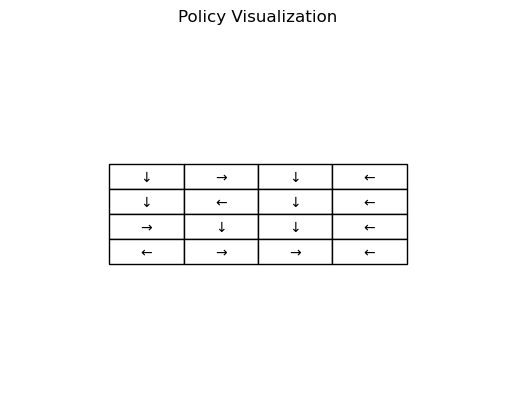

In [27]:
vi_policy, vi_V, vi_iterations, vi_deltas = value_iteration(env)
vi_success_rate = evaluate_policy(env, vi_policy, episodes=100)

# Print Value Iteration results
print(f"Value Iteration: Success Rate = {vi_success_rate*100:.2f}%, Iterations = {vi_iterations}")

# Visualize the learned policy
print_policy(vi_policy)

# Q-Learning Algorithm

In [ ]:
def q_learning(env, episodes=2000, alpha=0.1, gamma=0.99, epsilon=1.0, eval_interval=100):
     """
    Implements tabular Q-Learning with epsilon-greedy exploration.
    Args:
        env: OpenAI Gym environment.
        episodes (int): Number of training episodes.
        alpha (float): Learning rate.
        gamma (float): Discount factor.
        epsilon (float): Initial exploration rate.
        epsilon_decay (float): Epsilon decay rate per episode.
        min_epsilon (float): Minimum epsilon for exploration.
    Returns:
        policy (np.array): Learned policy.
        Q (np.array): Learned Q-table.
        rewards (list): Total reward per episode.
        success_rates (list): Success rate every 100 episodes.
    """
    Q = np.zeros((n_states, n_actions))
    success_rates = []
    q_rewards = []  # To store rewards for plotting

    # 🔥 Print Q-table before training
    print("Q-Table before training:\n")
    print(Q)

    # Main training loop
    for episode in range(1, episodes+1):
        state = env.reset()[0]
        done = False
        episode_rewards = 0  # To store the reward for this episode

        while not done:
            # ε-greedy action selection
            if np.random.rand() < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(Q[state])

            next_state, reward, done, _, _ = env.step(action)

            # Q-Table Update (TD Learning)
            best_next_action = np.argmax(Q[next_state])
            td_target = reward + gamma * Q[next_state, best_next_action]
            td_delta = td_target - Q[state, action]
            Q[state, action] += alpha * td_delta

            state = next_state
            episode_rewards += reward

        q_rewards.append(episode_rewards)  # Store the total reward for this episode

        # Evaluate policy every few episodes
        if episode % eval_interval == 0:
            policy = np.argmax(Q, axis=1)
            success = evaluate_policy(env, policy, episodes=50)
            success_rates.append(success)

    # 🔥 Print Q-table after training
    print("\nQ-Table after training:\n")
    print(Q)

    # Extract final policy
    policy = np.argmax(Q, axis=1)
    return policy, Q, success_rates, q_rewards

Q-Table before training:

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]

Q-Table after training:

[[0.77063598 0.76291646 0.78080096 0.77121391]
 [0.76653713 0.         0.79100444 0.77873877]
 [0.77183461 0.80473194 0.75209136 0.7840923 ]
 [0.77341993 0.         0.72232514 0.72329445]
 [0.75675595 0.77265484 0.         0.76887835]
 [0.         0.         0.         0.        ]
 [0.         0.82451673 0.         0.75277263]
 [0.         0.         0.         0.        ]
 [0.75481251 0.         0.78740735 0.742172  ]
 [0.71982954 0.77036392 0.81331868 0.        ]
 [0.7016459  0.87393506 0.         0.69172844]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.69005658 0.81443322 0.60252874]
 [0.6818485  0.76059254 0.93538918 0.65437091]
 [

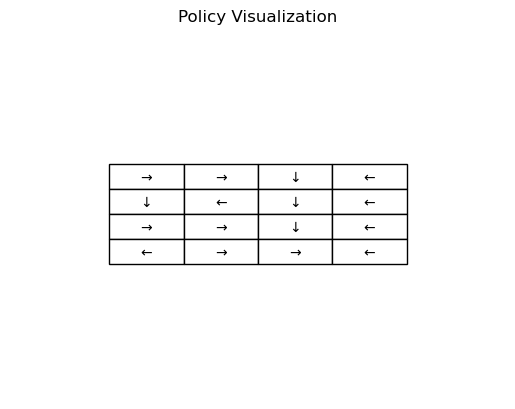

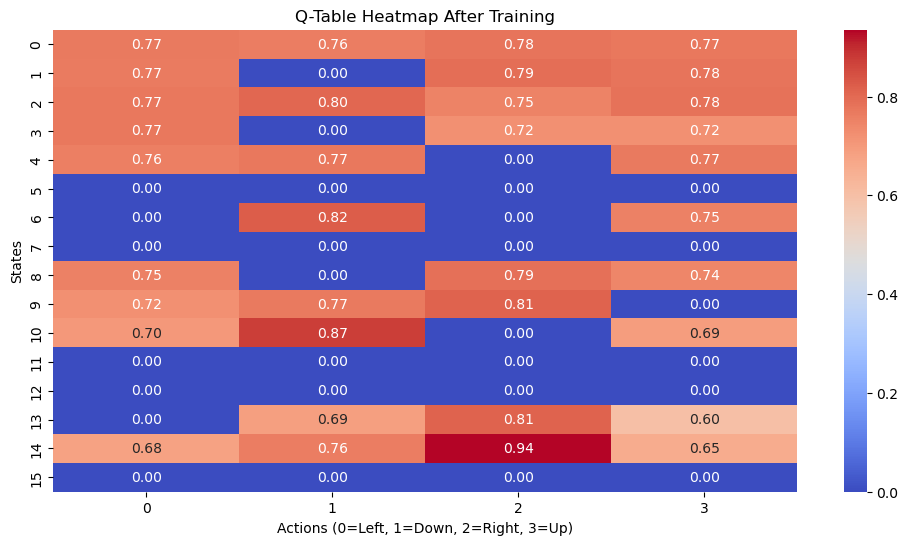

In [29]:
ql_policy, Q, success_rates,  q_rewards = q_learning(env, episodes=2000)

ql_success_rate = evaluate_policy(env, ql_policy, episodes=100)

# Print Q-Learning results
print(f"Q-Learning: Success Rate = {ql_success_rate*100:.2f}% after 2000 episodes")

# Visualize the learned policy
print_policy(ql_policy)



def plot_q_table(Q):
    plt.figure(figsize=(12, 6))
    sns.heatmap(Q, annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Q-Table Heatmap After Training")
    plt.xlabel("Actions (0=Left, 1=Down, 2=Right, 3=Up)")
    plt.ylabel("States")
    plt.show()

plot_q_table(Q)

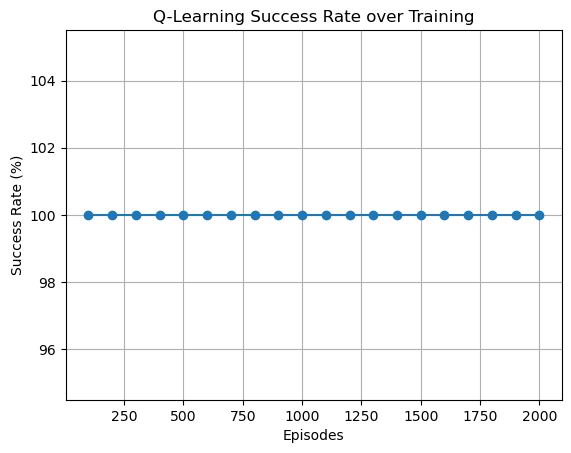

In [30]:
x = np.arange(100, 2001, 100)
y = np.array(success_rates) * 100

plt.plot(x, y, marker='o')
plt.title("Q-Learning Success Rate over Training")
plt.xlabel("Episodes")
plt.ylabel("Success Rate (%)")
plt.grid()
plt.show()


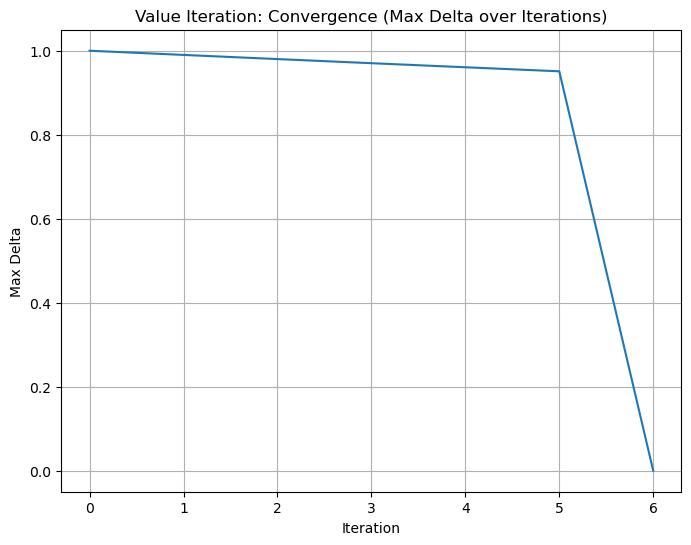

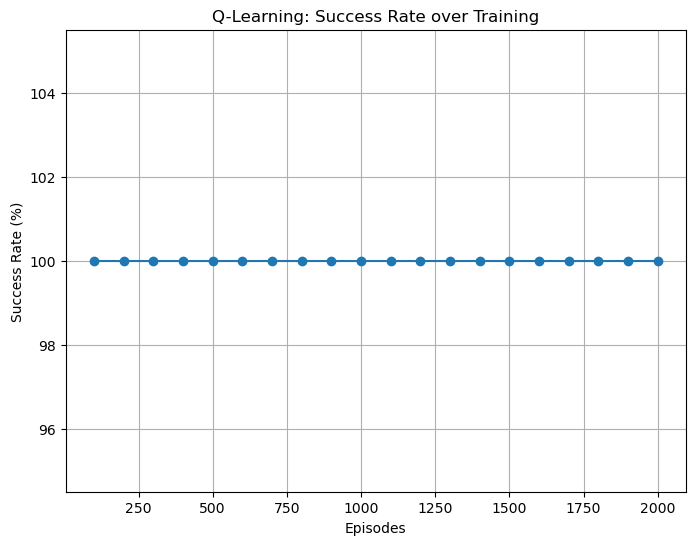

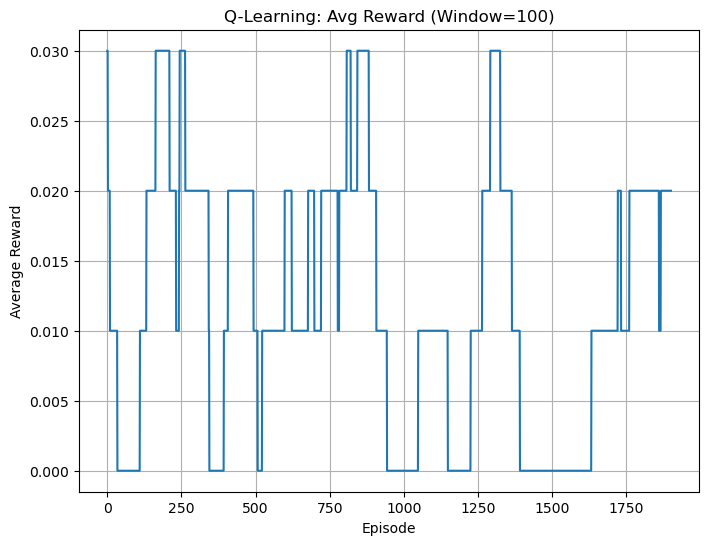

In [31]:
# Plot Value Iteration Convergence (Max Delta over iterations)
def plot_vi_convergence(deltas):
    plt.figure(figsize=(8, 6))
    plt.plot(deltas)
    plt.title("Value Iteration: Convergence (Max Delta over Iterations)")
    plt.xlabel("Iteration")
    plt.ylabel("Max Delta")
    plt.grid(True)
    plt.show()

# Plot Q-Learning Success Rate
def plot_ql_success_rate(success_rates):
    x = np.arange(100, 2001, 100)  # Evaluate every 100 episodes
    y = np.array(success_rates) * 100  # Success rates in percentage
    plt.figure(figsize=(8, 6))
    plt.plot(x, y, marker='o')
    plt.title("Q-Learning: Success Rate over Training")
    plt.xlabel("Episodes")
    plt.ylabel("Success Rate (%)")
    plt.grid(True)
    plt.show()




# Plot Q-Learning Reward Trend
def plot_ql_reward_trend(reward_trends):
    window = 100
    avg_rewards = np.convolve(reward_trends, np.ones(window) / window, mode="valid")
    plt.figure(figsize=(8, 6))
    plt.plot(avg_rewards)
    plt.title(f"Q-Learning: Avg Reward (Window={window})")
    plt.xlabel("Episode")
    plt.ylabel("Average Reward")
    plt.grid(True)
    plt.show()

# --- 1. Plot Value Iteration Convergence ---
plot_vi_convergence(vi_deltas)

# --- 2. Plot Q-Learning Success Rate ---
plot_ql_success_rate(success_rates)

# --- 3. Plot Q-Learning Reward Trend ---
plot_ql_reward_trend(q_rewards)